In [1]:
# NOTE:  This analysis notebook was tested on the data you can retrieve via the "rsync_from_nas.sh"

In [2]:
import matplotlib.pyplot as plt
import os, json
import numpy as np
import pandas as pd
import seaborn as sns
import re
import traceback

GEN_DFS = True # True if you need to read data from the json files, otherwise read dataframes from the csvs
WRITE_CSVS = True # True for overwriting csvs

/var/folders/8s/0nbb09xn775f4xp3tg4xfmmh0000gn/T/ipykernel_21233/3502222517.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
datadir = "./results/last_validation_3-25-2024_results/"
search_files = [datadir + x for x in os.listdir(datadir) if "search" in x]
upload_files = [datadir + x for x in os.listdir(datadir) if "upload" in x]
gsi_search = [x for x in search_files if "gsi" in x]
weaviate_files = [datadir + x for x in os.listdir(datadir) if "weaviate" in x]
weaviate_search = [x for x in weaviate_files if "search" in x]
weaviate_upload = [x for x in weaviate_files if "upload" in x]
qdrant_files = [datadir + x for x in os.listdir(datadir) if "qdrant" in x]
qdrant_search = [x for x in qdrant_files if "search" in x]
qdrant_upload = [x for x in qdrant_files if "upload" in x]
hnsw_search = [x for x in search_files if "hnswlib" in x and "gxl" not in x]
hnsw_upload = [x for x in upload_files if "hnswlib" in x and "gxl" not in x]
gxl_search = [x for x in search_files if "gxl" in x]
gxl_upload = [x for x in upload_files if "gxl" in x]

## Results

In [34]:
def parse_weav_search(fname):
    try:
        # filename parsing
        tmp = os.path.basename(fname).split('-')
        #print("parse weave", tmp)
        if tmp[1] == "gxl":
            if tmp[7].isnumeric():
                m, efc, dataset, dim = int(tmp[3]), int(tmp[5]), tmp[6], int(tmp[7])
            else:
                m, efc, dataset, dim = int(tmp[3]), int(tmp[5]), f"{tmp[6]}-{tmp[7]}", int(tmp[8])
        else:    
            if tmp[6].isnumeric():
                m, efc, dataset, dim = int(tmp[2]), int(tmp[4]), tmp[5], int(tmp[6])
            else:
                if tmp[2]=="deep":
                    print("Skipping ", fname, "...")
                    return None
                m, efc, dataset, dim = int(tmp[2]), int(tmp[4]), f"{tmp[5]}-{tmp[6]}", int(tmp[7])
        row = {'vdb': 'weaviate', 'm':m, 'efc': efc, 'dataset': dataset, 'dim': dim}
    
        # json file parse
        f = open(fname)
        tmp = json.load(f)
        row.update(tmp['params'].pop('vectorIndexConfig'))
        row.update(tmp['params'])
        row.update(tmp['results'])
        return row
    except E:
        print("Error with", fname, " so skipping it")
        traceback.print_exc()
        raise(E)
        #return None

In [35]:
def parse_gsi_search(fname):
    nbits, dim, dataset, m, efc, ef, new, nprobe, nprobe_rerank, hammingk = [None] * 10
    # filename parsing
    tmp = os.path.basename(fname).split('-')
    if "new" in fname:
        new = True
    elif "nprobe" in fname:
        nprobe, nprobe_rerank, hammingk = tmp[3], tmp[5], tmp[7]
    # get nbits, dims, and dataset
    search_type = tmp[2]
    # get hnsw params if available
    if search_type == "hnsw":
        if "-m-" not in fname:
            # set default values
            m, efc, ef = 32, 100, 100
        else:
            # pop 'm' and 'ef' values
            m, efc = tmp.pop(4), tmp.pop(5)
            # remove 'm' and 'ef'
            tmp.pop(3), tmp.pop(3)
    # get dataset and nbits params
    for i, x in enumerate(tmp):
        if x.isnumeric():
            if not nbits:
                nbits = int(x)
            elif not dim:
                if (nprobe and i > 7) or not nprobe:
                    if tmp[i-1] == "image":
                        dataset = f"{tmp[i-2]}-{tmp[i-1]}"
                        if tmp[i+2][0].isnumeric():
                            dataset += f"-{tmp[i+2]}"
                        else:
                            dataset += "-10M"
                        dim = int(tmp[i])
                    else:
                        dataset = f"{tmp[i-1]}"
                        dim = int(tmp[i])

    row = {'vdb': 'gsi', 'search_type': search_type, 'nbits': nbits, 'dataset': dataset, 'dim': dim, 
           'm':m, 'efc': efc, 'ef': ef, 'new': new, 'nprobe': nprobe, 'nprobe_rerank': nprobe_rerank, 'hammingk': hammingk,
           'fname': os.path.basename(fname) }
    # json file parse
    f = open(fname)
    tmp = json.load(f)
    # add json file data to row
    if '-m-' in fname:
        row.update(tmp['params'].pop('vectorIndexConfig'))
        row.update(tmp['params'])
    row.update(tmp['results'])
    return row

In [36]:
def parse_qdrant_search(fname):
    # filename parsing
    tmp = os.path.basename(fname).split('-')
    if "rps" in fname or "mmap" in fname: 
        mode = tmp.pop(1)
    else: 
        mode = 'default'
    if tmp[6].isnumeric():
        m, efc, dataset, dim = int(tmp[2]), int(tmp[4]), tmp[5], int(tmp[6])
    else:
        if tmp[9][0].isnumeric():
            m, efc, dataset, dim = int(tmp[2]), int(tmp[4]), f"{tmp[5]}-{tmp[6]}-{tmp[9]}", int(tmp[7])            
        else:
            m, efc, dataset, dim = int(tmp[2]), int(tmp[4]), f"{tmp[5]}-{tmp[6]}-10M", int(tmp[7])
    row = {'vdb': 'qdrant', 'm':m, 'efc': efc, 'dataset': dataset, 'dim': dim, 'mode': mode}

    # json file parse
    f = open(fname)
    tmp = json.load(f)
    row.update(tmp['params'].pop('search_params'))
    row.update(tmp['params'])
    row.update(tmp['results'])
    return row

In [37]:
def gen_gsi():# create GSI search results dataframe
    columns = ['vdb', 'search_type', 'nbits', 'dataset', 'dim', 'm', 'efc', 'ef', 'nprobe', 'nprobe_rerank', 'hammingk', 'new', 'total_time', 'mean_time',\
                'mean_precisions', 'std_time', 'min_time', 'max_time', 'rps', 'p95_time', 'p99_time',\
                'precisions', 'latencies','fname']
    gsi_df = pd.DataFrame(columns=columns)
    for fname in gsi_search:
        gsi_df.loc[len(gsi_df), :] = parse_gsi_search(fname)
    gsi_df.fillna(np.nan)
    gsi_df = gsi_df.astype({'m': float, 'efc': float, 'ef': float, 'dim': int, 'mean_precisions': float, 'mean_time': float})
    gsi_df = gsi_df.astype({'m': 'Int64', 'efc': 'Int64', 'ef': 'Int64'})
    gsi_df = gsi_df.sort_values(by=['search_type', 'dataset', 'dim', 'nbits']).reset_index(drop=True)
    gsi_df.new = gsi_df.new.fillna(False)
    gsi_df = gsi_df.astype({'new': 'Int64', 'nprobe': 'Int64', 'nprobe_rerank': 'Int64', 'hammingk': 'Int64'})
    gsi_df.new[66] = 2
    return gsi_df

In [38]:
def gen_weav_docker():# create weaviate search results dataframe
    columns = ['vdb', 'm', 'efc', 'ef', 'dataset', 'dim', 'parallel', 'total_time', 'mean_time',\
                'mean_precisions', 'std_time', 'min_time', 'max_time', 'rps', 'p95_time', 'p99_time',\
                'precisions', 'latencies']
    weav_df = pd.DataFrame(columns=columns)
    for fname in weaviate_search:
        row = parse_weav_search(fname)
        weav_df.loc[len(weav_df)] = row
    weav_df = weav_df.sort_values(by=['m', 'efc', 'dim', 'ef']).reset_index(drop=True)
    weav_df.parallel.fillna(0, inplace=True)
    weav_df_docker = weav_df.copy()
    return weav_df_docker

In [39]:
def gen_qdrant():# create qdrant search results dataframe
    columns = ['vdb', 'm', 'efc', 'hnsw_ef', 'dataset', 'dim', 'parallel', 'total_time', 'mean_time',\
                'mean_precisions', 'std_time', 'min_time', 'max_time', 'rps', 'p95_time', 'p99_time',\
                'precisions', 'latencies']
    qdrant_df = pd.DataFrame(columns=columns)
    for fname in qdrant_search:
        qdrant_df.loc[len(qdrant_df)] = parse_qdrant_search(fname)
    qdrant_df = qdrant_df.sort_values(by=['m', 'efc', 'dim', 'hnsw_ef']).reset_index(drop=True)
    return qdrant_df

In [40]:
def gen_hnsw():# create hnswlib search results dataframe
    hnsw_df = pd.DataFrame(columns=parse_weav_search(hnsw_search[0]).keys())
    for fname in hnsw_search:
        row = parse_weav_search(fname)
        if row==None: continue
        hnsw_df.loc[len(hnsw_df), :] = row
    hnsw_df.vdb = 'hnswlib'
    hnsw_df = hnsw_df.sort_values(['m', 'efc', 'ef', 'parallel']).reset_index(drop=True)
    return hnsw_df
def gen_gxl():# create gxl search results dataframe
    gxl_df = pd.DataFrame(columns=parse_weav_search(gxl_search[0]).keys())
    for fname in gxl_search:
        row = parse_weav_search(fname)
        gxl_df.loc[len(gxl_df), :] = row
    gxl_df.vdb = 'hnswlib_gxl'
    gxl_df = gxl_df.sort_values(['m', 'efc', 'ef']).reset_index(drop=True)
    return gxl_df

In [42]:
if GEN_DFS:
    gsi_df = gen_gsi()
    weav_df_docker = gen_weav_docker()
    qdrant_df = gen_qdrant()
    hnsw_df = gen_hnsw()
    #gw gxl_df = gen_gxl()
else:
    qdrant_df = pd.read_csv(os.path.join(datadir,'qdrant-df.csv'))
    weav_df_docker = pd.read_csv(os.path.join(datadir,'weaviate-df.csv'))
    gsi_df = pd.read_csv(os.path.join(datadir,'gsi-df.csv'))
    hnsw_df = pd.read_csv(os.path.join(datadir,'hnswlib-df.csv'))
    #gw gxl_df = pd.read_csv('results/gxl-df.csv')

if WRITE_CSVS:
    qdrant_df.to_csv(os.path.join(datadir,'qdrant-df.csv'), index=False)
    weav_df_docker.to_csv(os.path.join(datadir,'weaviate-df.csv'), index=False)
    gsi_df.to_csv(os.path.join(datadir,'gsi-df.csv'), index=False)
    hnsw_df.to_csv(os.path.join(datadir,'hnswlib-df.csv'), index=False)
    #gw gxl_df.to_csv('results/gxl-df.csv', index=False)

/var/folders/8s/0nbb09xn775f4xp3tg4xfmmh0000gn/T/ipykernel_21233/3206099506.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gsi_df.fillna(np.nan)
/var/folders/8s/0nbb09xn775f4xp3tg4xfmmh0000gn/T/ipykernel_21233/3206099506.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gsi_df.new = gsi_df.new.fillna(False)
/var/folders/8s/0nbb09xn775f4xp3tg4xfmmh0000gn/T/ipykernel_21233/3206099506.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain c

Skipping  ./results/last_validation_3-25-2024_results/hnswlib-default-deep-image-96-angular-search-0-2024-03-25-03-19-05.json ...


In [43]:
print(qdrant_df.columns)
qdrant_subset = qdrant_df[['mean_precisions','mean_time','p95_time','min_time','max_time','efc','m','hnsw_ef','parallel']]\
    .sort_values(['efc','m','hnsw_ef'])
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
#print(qdrant_subset)

Index(['vdb', 'm', 'efc', 'hnsw_ef', 'dataset', 'dim', 'parallel',
       'total_time', 'mean_time', 'mean_precisions', 'std_time', 'min_time',
       'max_time', 'rps', 'p95_time', 'p99_time', 'precisions', 'latencies'],
      dtype='object')


In [44]:
print(weav_df_docker.columns)
weav_subset = weav_df_docker[['mean_precisions','mean_time','p95_time','min_time','max_time','efc','m','ef','parallel']]\
    .sort_values(['efc','m','ef'])
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
#print(weav_subset)

Index(['vdb', 'm', 'efc', 'ef', 'dataset', 'dim', 'parallel', 'total_time', 'mean_time', 'mean_precisions', 'std_time', 'min_time', 'max_time', 'rps', 'p95_time', 'p99_time', 'precisions', 'latencies'], dtype='object')


In [45]:
print(hnsw_df.columns)
hnsw_subset = hnsw_df[['mean_precisions','mean_time','p95_time','min_time','max_time','efc','m','ef','parallel']]\
    .sort_values(['efc','m','ef'])
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
#print(hnsw_subset)

Index(['vdb', 'm', 'efc', 'dataset', 'dim', 'ef', 'parallel', 'total_time', 'mean_time', 'mean_precisions', 'std_time', 'min_time', 'max_time', 'rps', 'p95_time', 'p99_time', 'precisions', 'latencies'], dtype='object')


In [46]:
gsi_subset = gsi_df[['nbits','mean_precisions','mean_time','p95_time','p99_time','min_time','max_time','nprobe','nprobe_rerank','hammingk','new']]\
    .sort_values(["nprobe","nprobe_rerank","hammingk","new"])
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
#print(gsi_subset)

In [53]:
#
# Do some dataframe filtering
#

parallels = [1, 0]
dim = 96
size = "10M"
nprobes = [250, 850]

#
# Qdrant
#
qdrant_copy = qdrant_df.copy()
qdrant_copy = qdrant_copy[(qdrant_copy.dim == dim) & (qdrant_copy.parallel.isin(parallels)) & (qdrant_copy.dataset.str.contains(size))]
print(qdrant_copy.shape)

#
# Weaviate
#
weav_copy = weav_df_docker.copy()
weav_copy = weav_copy[(weav_copy.dim == dim) & (weav_copy.parallel.isin(parallels))]

#
# HNSW
#
hnsw_copy = hnsw_df.copy()
hnsw_copy = hnsw_copy[(hnsw_copy.dim == dim) & (hnsw_copy.parallel.isin(parallels))]

#
# GSI FVS
#
# new = 1 (this was in the original notebook)
gsi_copy = gsi_df.copy()
gsi_nprobe_copy = gsi_copy[(gsi_copy.dim == dim) & (gsi_copy.new == 1) & (gsi_copy.dataset.str.contains(size))]
print(gsi_nprobe_copy.shape)
if gsi_nprobe_copy.shape[0]>0:
    raise Exception("This notebook does not deal with new=1.  Please ask Jacob/George if you get this error.")
# default FVS settings
#GW gsi_fvs_copy = gsi_copy[(gsi_copy.dim == dim) & (gsi_copy.dataset.str.contains(size) & (gsi_copy.nprobe.isna()) & (gsi_copy.new == 0))]#.drop(52)
gsi_fvs_default_copy = gsi_copy[(gsi_copy.dim == dim) & (gsi_copy.dataset.str.contains(size) & (gsi_copy.nprobe.isna()) & (gsi_copy.new == 0))]
print(gsi_fvs_default_copy.shape)
# explicit FVS settings
gsi_fvs_copy = gsi_copy[(gsi_copy.dim == dim) & (gsi_copy.dataset.str.contains(size)) & ~(gsi_copy.nprobe.isna())]
print(gsi_fvs_copy.shape)                                                                                      

#
# GXL
#
#GW gxl_copy = gxl_df.copy()
#GW gxl_copy = gxl_copy[(gxl_copy.dim == dim) & (gxl_copy.parallel.isin(parallels))]

(28, 18)
(0, 24)
(13, 24)
(52, 24)


In [54]:
print(qdrant_copy.columns)
qdrant_subset = qdrant_copy[['mean_precisions','mean_time','p95_time','p99_time','min_time','max_time','efc','m','hnsw_ef','parallel']]\
    .sort_values(['efc','m','hnsw_ef'])
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
#print(qdrant_subset)

Index(['vdb', 'm', 'efc', 'hnsw_ef', 'dataset', 'dim', 'parallel', 'total_time', 'mean_time', 'mean_precisions', 'std_time', 'min_time', 'max_time', 'rps', 'p95_time', 'p99_time', 'precisions', 'latencies'], dtype='object')


In [55]:
print(weav_copy.columns)
weaviate_subset = weav_copy[['mean_precisions','mean_time','p95_time','p99_time','min_time','max_time','efc','m','ef','parallel']]\
    .sort_values(['efc','m','ef'])
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
#print(weaviate_subset)

Index(['vdb', 'm', 'efc', 'ef', 'dataset', 'dim', 'parallel', 'total_time', 'mean_time', 'mean_precisions', 'std_time', 'min_time', 'max_time', 'rps', 'p95_time', 'p99_time', 'precisions', 'latencies'], dtype='object')


In [56]:
print(hnsw_copy.columns)
hnsw_copy = hnsw_copy[['mean_precisions','mean_time','p95_time','p99_time','min_time','max_time','efc','m','ef','parallel']]\
    .sort_values(['efc','m','ef'])
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
#print(hnsw_copy)

Index(['vdb', 'm', 'efc', 'dataset', 'dim', 'ef', 'parallel', 'total_time', 'mean_time', 'mean_precisions', 'std_time', 'min_time', 'max_time', 'rps', 'p95_time', 'p99_time', 'precisions', 'latencies'], dtype='object')


In [51]:
#
# Prepare for pareto front plot via paraemeter groupby
#
gb = weav_copy.groupby(['efc', 'm', 'ef']).agg({'mean_precisions': 'mean', 'mean_time': 'mean'})
weav_copy = gb.reset_index()
gb = qdrant_copy.groupby(['efc', 'm', 'hnsw_ef']).agg({'mean_precisions': 'mean', 'mean_time': 'mean'})
qdrant_copy = gb.reset_index()
gb = hnsw_copy.groupby(['efc', 'm', 'ef']).agg({'mean_precisions': 'mean', 'mean_time': 'mean'})
hnsw_copy = gb.reset_index()
#gw gb = gxl_copy.groupby(['efc', 'm', 'ef']).agg({'mean_precisions': 'mean', 'mean_time': 'mean'})
#gw gxl_copy = gxl_copy.reset_index()

gsi_default_configs= []


/var/folders/8s/0nbb09xn775f4xp3tg4xfmmh0000gn/T/ipykernel_21233/3119906885.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gsi_fvs_default_copy['label']='default'
/var/folders/8s/0nbb09xn775f4xp3tg4xfmmh0000gn/T/ipykernel_21233/3119906885.py:102: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


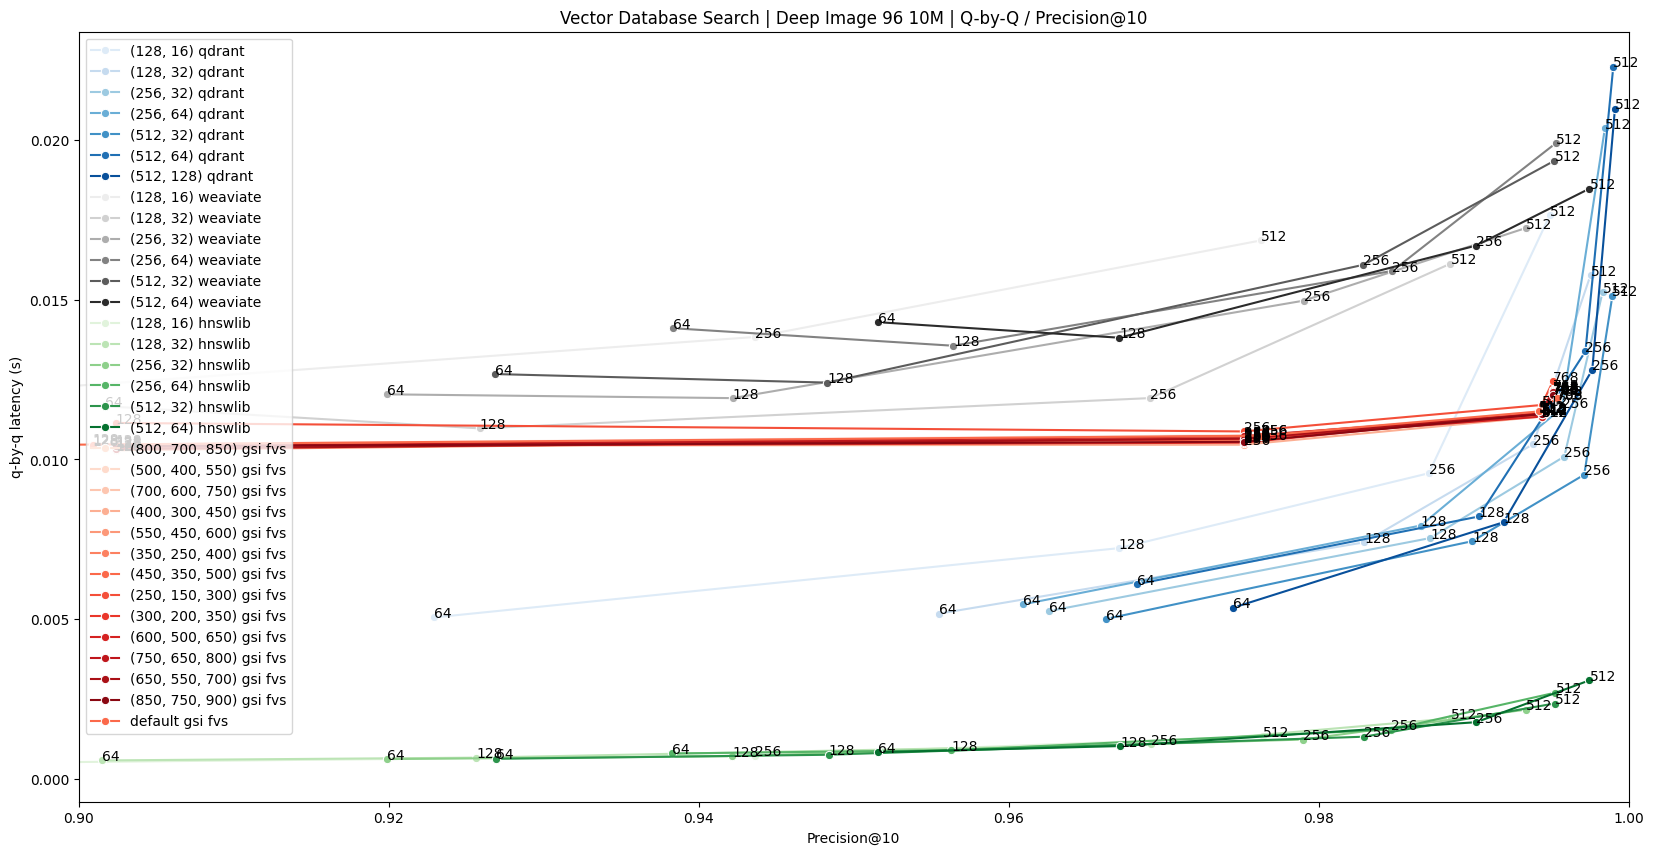

In [52]:
#
# Primary plot with everything
#
show_quadrant = True
show_weaviate = True
show_hnswlib = True
show_gsi_fvs = True
show_gxl = False

fig, ax = plt.subplots(figsize=(20,10))

qdrant_configs = qdrant_copy.groupby(["efc", "m"]).count().index.to_list()
weav_configs = weav_copy.groupby(["efc", "m"]).count().index.to_list()
hnsw_configs = hnsw_copy.groupby(["efc", "m"]).count().index.to_list()
#gw gxl_configs = gxl_copy.groupby(["efc", "m"]).count().index.to_list()
#gw
gsi_configs = gsi_fvs_copy.groupby(["nprobe","nprobe_rerank","hammingk"]).count().index.to_list()
#gw gsi_configs = gsi_nprobe_copy.groupby("nprobe").count().index.to_list()
gsi_default_configs = gsi_fvs_default_copy.groupby(["nprobe"]).count().index.to_list()
print("gsi_default_configs=", gsi_default_configs)

ax.set_title(f"Vector Database Search | Deep Image 96 {size} | Q-by-Q / Precision@10")
ax.set_xlabel("Precision@10")
ax.set_ylabel("q-by-q latency (s)")
ax.set_xlim([0.9,1.0])

if show_quadrant:
    palette = sns.color_palette("Blues", len(qdrant_configs))
    sns.lineplot(data=qdrant_copy, x="mean_precisions", y="mean_time", hue=qdrant_copy[["efc", "m"]].apply(tuple, axis=1), marker="o", palette=palette)
    for ef, x, y in zip(qdrant_copy.hnsw_ef, qdrant_copy.mean_precisions, qdrant_copy.mean_time):
        plt.annotate(ef, (x, y))

if show_weaviate:
    palette = sns.color_palette("Greys", len(weav_configs))
    sns.lineplot(data=weav_copy, x="mean_precisions", y="mean_time", hue=weav_copy[["efc", "m"]].apply(tuple, axis=1), marker="o", palette=palette)
    for ef, x, y in zip(weav_copy.ef, weav_copy.mean_precisions, weav_copy.mean_time):
        plt.annotate(ef, (x, y))

if show_hnswlib:
    palette = sns.color_palette("Greens", len(hnsw_configs))
    sns.lineplot(data=hnsw_copy, x="mean_precisions", y="mean_time", hue=hnsw_copy[["efc", "m"]].apply(tuple, axis=1), marker="o", palette=palette)
    for ef, x, y in zip(hnsw_copy.ef, hnsw_copy.mean_precisions, hnsw_copy.mean_time):
        plt.annotate(ef, (x,y))

if show_gxl:
    palette = sns.color_palette("Purples", len(gxl_configs))
    sns.lineplot(data=gxl_copy, x="mean_precisions", y="mean_time", hue=gxl_copy[["efc", "m"]].apply(tuple, axis=1), marker="o", palette=palette)
    for ef, x, y in zip(gxl_copy.ef, gxl_copy.mean_precisions, gxl_copy.mean_time):
        plt.annotate(ef, (x,y))

#gw
if show_gsi_fvs:
    palette = sns.color_palette("Reds", len(gsi_configs))
    sns.lineplot(data=gsi_fvs_copy, x="mean_precisions", y="mean_time", 
                 hue=gsi_fvs_copy[["nprobe","nprobe_rerank","hammingk"]].apply(tuple, axis=1), 
                 marker="o", palette=palette)
    for _, row in gsi_fvs_copy.iterrows():
        plt.annotate(row.nbits, (row.mean_precisions, row.mean_time))
    #gw palette = sns.color_palette("Reds", 2)
    #gw sns.lineplot(data=gsi_nprobe_copy, x="mean_precisions", y="mean_time", hue=gsi_nprobe_copy[["dataset"]].apply(tuple, axis=1), marker="o", palette=palette)
    #gw for _, row in gsi_nprobe_copy.iterrows():
    #gw    plt.annotate(row.nbits, (row.mean_precisions, row.mean_time))
    #gw
    palette = sns.color_palette("Reds", 1)
    gsi_fvs_default_copy['label']='default'
    sns.lineplot(data=gsi_fvs_default_copy, x="mean_precisions", 
                 y="mean_time", hue="label", 
                 marker="o", palette=palette)
    for _, row in gsi_fvs_default_copy.iterrows():
        plt.annotate(row.nbits, (row.mean_precisions, row.mean_time))
#gw
if show_gxl:
    #gw palette = sns.color_palette("plasma", 1)
    #gw sns.lineplot(data=gsi_fvs_copy, x="mean_precisions", y="mean_time", hue="dataset", marker="o", palette=palette)
    #gw for _, row in gsi_fvs_copy.iterrows():
    #gw    plt.annotate(row.nbits, (row.mean_precisions, row.mean_time))
    pass

leg = ax.legend(loc='upper left')
curr = 0
if show_quadrant:
    [x.set_text(x.get_text() + ' qdrant') for x in leg.get_texts()[:len(qdrant_configs)]]
    curr += len(qdrant_configs)
if show_weaviate:
    [x.set_text(x.get_text() + ' weaviate') for x in leg.get_texts()[curr:curr + len(weav_configs)]]
    curr += len(weav_configs)
if show_hnswlib:
    [x.set_text(x.get_text() + ' hnswlib') for x in leg.get_texts()[curr:curr + len(hnsw_configs)]]
    curr += len(hnsw_configs)
#gw
if show_gsi_fvs:
    [x.set_text(x.get_text() + ' gsi fvs') for x in leg.get_texts()[curr:curr + len(gsi_configs)]]
    curr += len(gsi_configs)
    [x.set_text(x.get_text() + ' gsi fvs') for x in leg.get_texts()[curr:curr + 1]]
    curr += 1

if show_gxl:
    #gw [x.set_text(x.get_text() + ' GXL (CPU)') for x in leg.get_texts()[curr:curr + len(gxl_configs)]]
    #gw curr += len(gxl_configs)
    pass

#gw [x.set_text( 'Noam config 1 GSI') for x in leg.get_texts()[curr:curr + 1]]
#gw [x.set_text('default FVS GSI') for x in leg.get_texts()[-1:]]

fig.show()
fig.savefig("./results/deep-10M.png")

In [21]:
raise Exception("Do Not Run Past This Cell - The Remainer Is Not Fully Tested.")

Exception: Do Not Run Past This Cell - The Remainer Is Not Fully Tested.

## Upload

In [ ]:
gxlu = pd.read_json(gxl_upload[0])
row = {}
row.update(gxlu['params']['vectorIndexConfig'])
row.update(gxlu.results[~gxlu.results.isna()].to_dict())
row.pop('ef')
row['dataset'] = None
gxlu = pd.DataFrame(columns=row.keys())
for path in [x for x in gxl_upload if "deep-image" in x]:
    tmp = pd.read_json(path)
    row = {}
    row.update(tmp['params']['vectorIndexConfig'])
    row.update(tmp.results[~tmp.results.isna()].to_dict())
    row.pop('ef')
    row['dataset'] = path.split('-')[6]
    gxlu.loc[len(gxlu), :] = row
gxlu.reset_index(drop=True, inplace=True)
gxlu.index = ['gxl\n' + str(x) for x in gxlu.groupby(['maxConnections', 'efConstruction']).count().index.to_list()]
gxlu.drop(['maxConnections', 'efConstruction'], axis = 1, inplace=True)
gxlu['total_time'] = gxlu[['cen_gen', 'knn_gen', 'knn_sym', 'idx_gen']].sum(axis=1)

In [ ]:
qdrantu = pd.read_json(qdrant_upload[0])
row = {}
row.update(qdrantu['params']['hnsw_config'])
row.update(qdrantu['results'][~qdrantu['results'].isna()].to_dict())
row.pop('post_upload')
row['dataset'] = None
qdrantu = pd.DataFrame(columns=row.keys())
for path in [x for x in qdrant_upload if "deep-image" in x]:
    tmp = pd.read_json(path)
    row = {}
    row.update(tmp['params']['hnsw_config'])
    row.update(tmp['results'][~tmp['results'].isna()].to_dict())
    row.pop('post_upload')
    tmp = path.split('-')[5:10]
    if tmp[-1][:-1].isnumeric():
        row['dataset'] = tmp[-1]
    else:
        row['dataset'] = '10M'
    qdrantu.loc[len(qdrantu), :] = row

gb_cols = ['ef_construct', 'm', 'dataset']
tmp = qdrantu.groupby(gb_cols).count().index.to_list()
qdrantu.index = ['qdrant\n' + str(x) for x in tmp]
qdrantu.drop(gb_cols, axis = 1, inplace=True)

In [ ]:
hnswu = pd.read_json(hnsw_upload[0])
row = {}
row.update(hnswu['params']['vectorIndexConfig'])
row.update(hnswu['results'][~hnswu['results'].isna()].to_dict())
row.pop('post_upload')
hnswu = pd.DataFrame(columns=row.keys())
for path in [x for x in hnsw_upload if "deep-image" in x]:
    tmp = pd.read_json(path)
    row = {}
    row.update(tmp['params']['vectorIndexConfig'])
    row.update(tmp['results'][~tmp['results'].isna()].to_dict())
    row['dataset'] = path.split('-')[5]
    hnswu.loc[len(hnswu), :] = row
hnswu.index = ['hnsw\n' + str(x) for x in hnswu.groupby(['efConstruction', 'maxConnections']).count().index.to_list()]
hnswu.drop(['maxConnections', 'efConstruction'], axis=1, inplace=True)

In [ ]:
fig, ax = plt.subplots(figsize=(25,15))
sns.barplot(x=hnswu.index, y=hnswu.total_time)
sns.barplot(x=gxlu.index, y=gxlu.total_time)
sns.barplot(x=qdrantu.index, y=qdrantu.total_time)
fig.show()

## Search Beyond 10M

In [ ]:
keep = ["10M", "50M", "100M"]
weav_files = [x for x in os.listdir("results") if "algodirect" in x]
rows = []
topk = 10
# 10M
for path in weav_files:
    split = re.split(r'_|-', path[:-4])
    size, ef = split[4], int(split[6])
    if size not in keep:
        continue
    path = os.path.join("results", path)
    tmp = pd.read_csv(path)
    tmp['inds'] = tmp['inds'].apply(lambda x: list(map(int, x.split("-"))))
    gt = np.load(f"data/deep-{size}-gt-1000.npy")
    precisions = []
    for i in range(tmp.shape[0]):
        precisions.append(len(np.intersect1d(gt[i][:topk], tmp.inds[i])) / topk)

    mean_precisions = np.mean(precisions)
    mean_time = np.mean(tmp.search_time)
    rows.append({'vdb': 'weaviate','size': size, 'm':64, 'efc': 64, 'ef': ef, 'mean_precisions': mean_precisions, 'mean_time': mean_time})
    
weav_df = pd.DataFrame(rows)

In [ ]:
size = "100M"

# qdrant configs
parallel = 1
m, efc = 16, 128
qdrant_copy = qdrant_df[(qdrant_df.parallel == 1) & (qdrant_df.efc == efc) & (qdrant_df.m == m) & (qdrant_df.dataset.str.contains(size))]
# gsi configs
nprobe = 250
gsi_copy = gsi_df[(gsi_df.dataset.str.contains(size)) & (gsi_df.nprobe == nprobe)].reset_index(drop=True)
# weaviate AD configs
weav_copy = weav_df[(weav_df["size"] == size)].sort_values('ef').reset_index(drop=True)
# weaviate native configs
weav_docker_copy = weav_df_docker[(weav_df_docker["dim"] == 96) & (weav_df_docker["efc"] == efc) & (weav_df_docker.m == m)\
                                & (weav_df_docker["parallel"] == parallel)].sort_values('ef').reset_index(drop=True)
# qdrant configs
qdrant_copy = qdrant_df[(qdrant_df.parallel == 1) & (qdrant_df.efc == efc) & (qdrant_df.m == m) & (qdrant_df.dataset.str.contains(size))].reset_index(drop=True)

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

# weaviate lines
palette = sns.color_palette('Reds', 1)
sns.lineplot(data = weav_copy, x = "mean_precisions", y = "mean_time", hue=weav_copy["size"], marker="o", palette=palette)
for _, row in weav_copy.iterrows():
    plt.annotate(row["ef"], (row["mean_precisions"], row["mean_time"]))

# qdrant lines
palette = sns.color_palette('Blues', 1)
sns.lineplot(data=qdrant_copy, x="mean_precisions", y="mean_time", hue=qdrant_copy["dataset"].apply(lambda x: x[11:]), marker="o", palette=palette)
for _, row in qdrant_copy.iterrows():
    plt.annotate(row["hnsw_ef"], (row["mean_precisions"], row["mean_time"]))

palette = sns.color_palette('Greens', 1)
sns.lineplot(gsi_copy, x="mean_precisions", y="mean_time", hue=gsi_copy.dataset.apply(lambda x: x[11:]), marker="o", palette=palette)
for _, row in gsi_copy.iterrows():
    plt.annotate(row["nbits"], (row["mean_precisions"], row["mean_time"]))

# palette = sns.color_palette("Purples", 1)
# sns.lineplot(weav_docker_copy, x="mean_precisions", y="mean_time", hue=weav_docker_copy.dataset, marker="o", palette=palette)
# for _, row in weav_docker_copy.iterrows():
    # plt.annotate(row.ef, (row.mean_precisions, row.mean_time))

leg = ax.legend()
leg.get_texts()[0].set_text(f"weaviate algo direct m: {weav_copy.m.unique()[0]} ef: {weav_copy.efc.unique()[0]}")
leg.get_texts()[1].set_text(f"qdrant m: {qdrant_copy.m[0]} ef: {qdrant_copy.efc[0]}")
leg.get_texts()[2].set_text(f"gsi clusters, nprobe: {gsi_copy.nprobe[0]}") 
# leg.get_texts()[3].set_text(f"weaviate native m: {weav_docker_copy.m[0]} ef: {weav_docker_copy.efc[0]}")

ax.set_title(f"Vector Database Search | Deep Image 96, {size} | Q-by-Q / Precision@10")
ax.set_xlabel("Precision@10")
ax.set_ylabel("q-by-q latency (s)")

fig.show()

In [ ]:
weav_copy = weav_df[(weav_df["size"] == "10M")].sort_values('ef').reset_index(drop=True)


fig, ax = plt.subplots(figsize=(20,10))
weav_df_docker_copy = weav_df_docker[(weav_df_docker.dataset.str.contains("deep-image")) & (weav_df_docker.parallel == 1) & (weav_df_docker.m == 16)].sort_values('ef')

ax.plot(weav_df_docker_copy['mean_precisions'], weav_df_docker_copy['mean_time'], marker="o")
for _, row in weav_df_docker_copy.iterrows():
    ax.annotate(row.ef, (row.mean_precisions, row.mean_time))

ax.plot(weav_copy['mean_precisions'], weav_copy['mean_time'], marker="o")
for _, row in weav_copy.iterrows():
    ax.annotate(row.ef, (row.mean_precisions, row.mean_time))

ax.legend(['weaviate docker', 'weaviate algo direct'], loc='upper left')
ax.set_title(("weaviate vs algo direct | deep image 96, 10M"))
ax.set_xlabel("Precision@10")
ax.set_ylabel("q-by-q latency (s)")
fig.show()